# Logistic Regression Demo

## Init

First, we load our libraries.  This makes use of the R `plotROC` package; it is available in Conda with

    conda install -c mdekstrand r-plotroc

In [1]:
library(tidyverse)
library(modelr)
library(plotROC)
library(psych)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: 'psych'

The following object is masked from 'package:modelr':

    heights

The following objects are masked from 'package:ggplot2':

    %+%, alpha



In [2]:
options(repr.plot.height=4.5, repr.matrix.max.rows=10)

And we want to load the data. Fun trick, `readr` can read URLs!

In [3]:
students = read_csv("https://stats.idre.ucla.edu/stat/data/binary.csv")
students

Parsed with column specification:
cols(
  admit = col_integer(),
  gre = col_integer(),
  gpa = col_double(),
  rank = col_integer()
)


admit,gre,gpa,rank
0,380,3.61,3
1,660,3.67,3
1,800,4.00,1
1,640,3.19,4
0,520,2.93,4
...,...,...,...
0,620,4.00,2
0,560,3.04,3
0,460,2.63,2
0,700,3.65,2


## Transformations

What does the logit function look like?

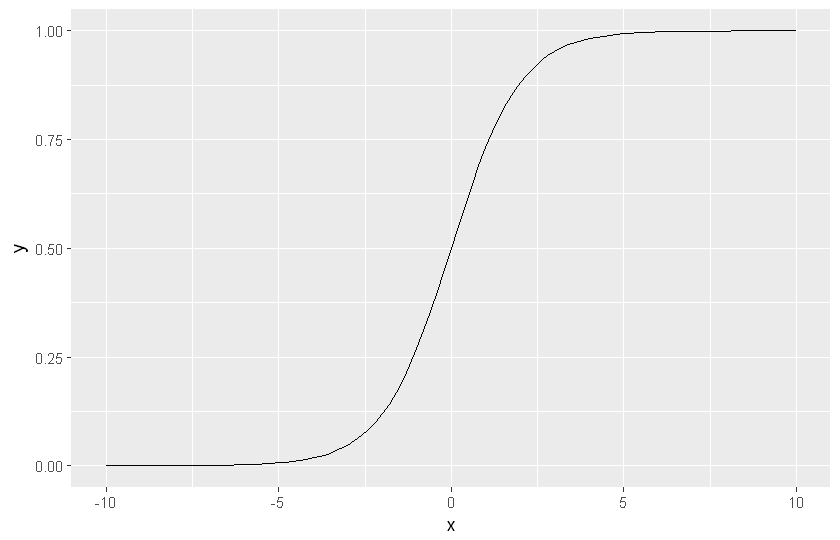

In [4]:
ggplot(data.frame(x=seq(-10, 10, 0.01))) +
    aes(x) +
    stat_function(fun=logistic)

## Logistic Regression

New function: `glm`; works a lot like `lm`!

`family` says _what kind_ of general regression; `binomial` is binary classifier.

In [5]:
zscore = function(x) {
    (x - mean(x)) / sd(x)
}

In [6]:
full_model = glm(admit ~ gpa + gre + rank, data=students,
                 family=binomial())
summary(full_model)


Call:
glm(formula = admit ~ gpa + gre + rank, family = binomial(), 
    data = students)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5802  -0.8848  -0.6382   1.1575   2.1732  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.449548   1.132846  -3.045  0.00233 ** 
gpa          0.777014   0.327484   2.373  0.01766 *  
gre          0.002294   0.001092   2.101  0.03564 *  
rank        -0.560031   0.127137  -4.405 1.06e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 499.98  on 399  degrees of freedom
Residual deviance: 459.44  on 396  degrees of freedom
AIC: 467.44

Number of Fisher Scoring iterations: 4


In [7]:
std_model = glm(admit ~ zscore(gpa) + zscore(gre) + rank, data=students,
                 family=binomial())
summary(std_model)


Call:
glm(formula = admit ~ zscore(gpa) + zscore(gre) + rank, family = binomial(), 
    data = students)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5802  -0.8848  -0.6382   1.1575   2.1732  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.5326     0.3154   1.689   0.0913 .  
zscore(gpa)   0.2957     0.1246   2.373   0.0177 *  
zscore(gre)   0.2650     0.1261   2.101   0.0356 *  
rank         -0.5600     0.1271  -4.405 1.06e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 499.98  on 399  degrees of freedom
Residual deviance: 459.44  on 396  degrees of freedom
AIC: 467.44

Number of Fisher Scoring iterations: 4


Let's do some checks for multicolinearity. The _correlation matrix_ of the variables:

In [8]:
cor(select(students, -admit))

,gre,gpa,rank
gre,1.0000000,0.38426588,-0.12344707
gpa,0.3842659,1.00000000,-0.05746077
rank,-0.1234471,-0.05746077,1.00000000


Looks like GRE and GPA might be linked?

`geom_smooth()` using method = 'loess'


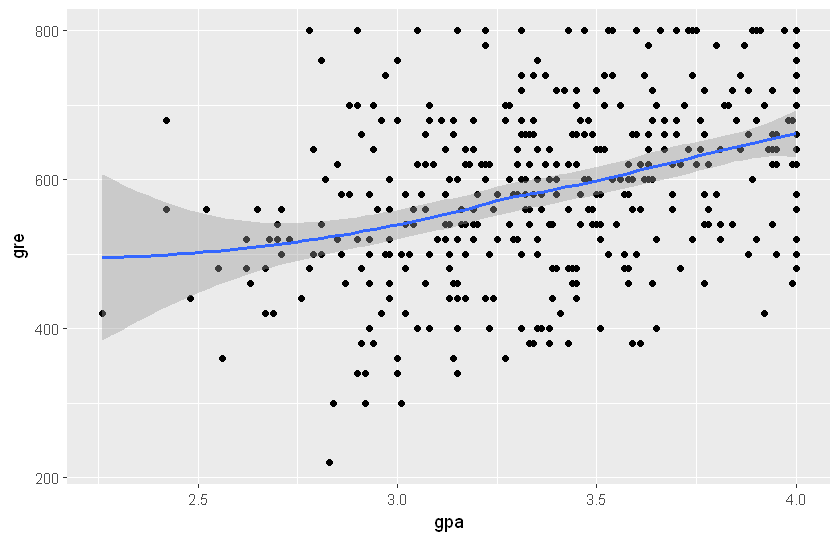

In [9]:
ggplot(students) +
    aes(x=gpa, y=gre) +
    geom_point() + geom_smooth()

## Effectiveness of Classifier

First, make train-test data

1. Add a `id` column
2. Sample rows
3. anti-join to make train data

How many rows are we sampling from?

In [10]:
nrow(students)

[1] 400

In [11]:
students_with_ids = students %>%
    mutate(id=1:n())

Let's go!

In [12]:
test_students = students_with_ids %>%
    sample_frac(0.1)
nrow(test_students)

[1] 40

The train data is everything that isn't test data.

In [13]:
train_students = students_with_ids %>%
    anti_join(select(test_students, id))
nrow(train_students)

Joining, by = "id"


[1] 360

Now we will train the model on the training data:

In [14]:
train_model_full = glm(admit ~ gpa + gre + rank, train_students, family=binomial())
summary(train_model_full)


Call:
glm(formula = admit ~ gpa + gre + rank, family = binomial(), 
    data = train_students)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5523  -0.9008  -0.6589   1.1891   2.1060  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.095586   1.170209  -2.645  0.00816 ** 
gpa          0.740721   0.340135   2.178  0.02943 *  
gre          0.001933   0.001144   1.690  0.09100 .  
rank        -0.543171   0.133631  -4.065 4.81e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 455.47  on 359  degrees of freedom
Residual deviance: 422.47  on 356  degrees of freedom
AIC: 430.47

Number of Fisher Scoring iterations: 3


Let's generate some predictions with it

In [15]:
test_preds = test_students %>%
    add_predictions(train_model_full)
test_preds

admit,gre,gpa,rank,id,pred
0,440,3.22,1,12,-0.4029496
0,560,3.49,4,376,-1.6004636
1,800,3.70,1,119,0.6486131
0,440,2.48,4,49,-2.5805971
0,800,3.31,3,201,-0.7266108
...,...,...,...,...,...
1,680,3.85,3,64,-0.5586271
1,800,3.22,1,287,0.2930671
0,660,3.34,3,55,-0.9750623
0,560,3.19,3,57,-1.2795084


What threshold to use?

Balance:

- catching them all (recall)
- catching things that aren't (precision)

Use ROC (Receiver Operating Characteristic) curve to view change in rates as we shift threshold.  `geom_roc` uses 2 aesthetics: `d` is the decision, `m` is the prediction estimate (numeric).

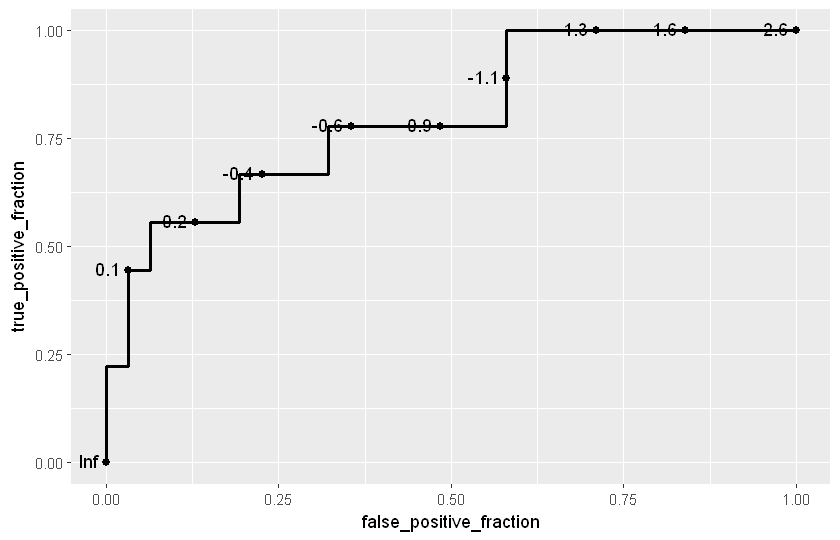

In [16]:
full_roc = ggplot(test_preds) +
    aes(d=admit, m=pred) +
    geom_roc()
full_roc

In [17]:
calc_auc(full_roc)

PANEL,group,AUC
1,-1,0.7992832


## Smaller Models

What if we just use GPA?

In [18]:
train_gpa_model = glm(admit ~ gpa, train_students, family=binomial())
summary(train_gpa_model)


Call:
glm(formula = admit ~ gpa, family = binomial(), data = train_students)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.1198  -0.9057  -0.7695   1.3337   1.9429  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -4.1527     1.0736  -3.868  0.00011 ***
gpa           1.0039     0.3098   3.241  0.00119 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 455.47  on 359  degrees of freedom
Residual deviance: 444.47  on 358  degrees of freedom
AIC: 448.47

Number of Fisher Scoring iterations: 4


In [19]:
test_gpa_preds = test_students %>%
    add_predictions(train_gpa_model)
test_gpa_preds

admit,gre,gpa,rank,id,pred
0,440,3.22,1,12,-0.9200143
0,560,3.49,4,376,-0.6489514
1,800,3.70,1,119,-0.4381247
0,440,2.48,4,49,-1.6629274
0,800,3.31,3,201,-0.8296600
...,...,...,...,...,...
1,680,3.85,3,64,-0.2875342
1,800,3.22,1,287,-0.9200143
0,660,3.34,3,55,-0.7995419
0,560,3.19,3,57,-0.9501324


Stack the data!

In [39]:
test_mm_preds =
    bind_rows(Full=test_preds,
              GPA=test_gpa_preds,
              .id="Model")
test_mm_preds

Model,admit,gre,gpa,rank,id,pred
Full,0,440,3.22,1,12,-0.4029496
Full,0,560,3.49,4,376,-1.6004636
Full,1,800,3.70,1,119,0.6486131
Full,0,440,2.48,4,49,-2.5805971
Full,0,800,3.31,3,201,-0.7266108
...,...,...,...,...,...,...
GPA,1,680,3.85,3,64,-0.2875342
GPA,1,800,3.22,1,287,-0.9200143
GPA,0,660,3.34,3,55,-0.7995419
GPA,0,560,3.19,3,57,-0.9501324


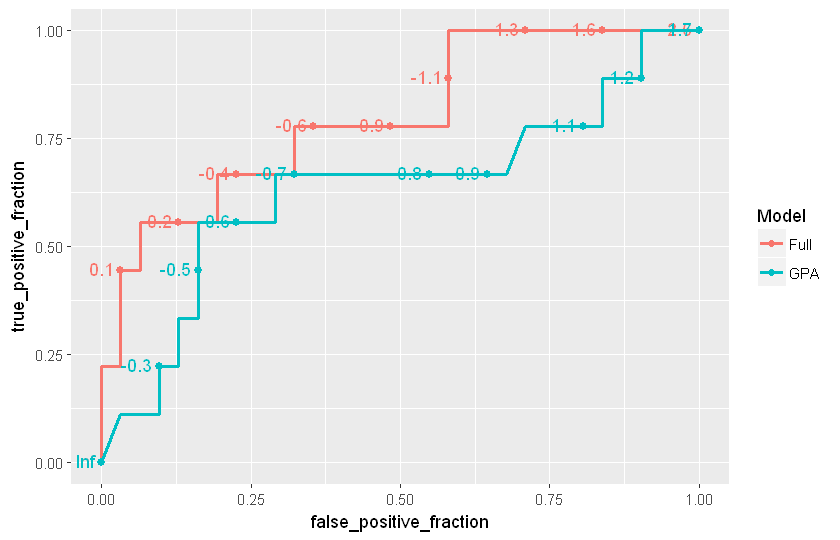

In [40]:
mm_plot = ggplot(test_mm_preds) +
    aes(d=admit, m=pred, color=Model) +
    geom_roc()
mm_plot

In [41]:
calc_auc(mm_plot)

PANEL,group,AUC
1,1,0.7992832
1,2,0.6344086


## Decision Trees

In [42]:
library(rpart)

In [43]:
tree = rpart(admit ~ gre + gpa + rank, train_students, method="class")
summary(tree)

Call:
rpart(formula = admit ~ gre + gpa + rank, data = train_students, 
    method = "class")
  n= 360 

          CP nsplit rel error    xerror       xstd
1 0.04237288      0 1.0000000 1.0000000 0.07547714
2 0.01694915      4 0.8220339 0.9576271 0.07461986
3 0.01271186      5 0.8050847 1.0084746 0.07563952
4 0.01000000      8 0.7627119 1.0254237 0.07595535

Variable importance
rank  gpa  gre 
  42   40   17 

Node number 1: 360 observations,    complexity param=0.04237288
  predicted class=0  expected loss=0.3277778  P(node) =1
    class counts:   242   118
   probabilities: 0.672 0.328 
  left son=2 (169 obs) right son=3 (191 obs)
  Primary splits:
      rank < 2.5   to the right, improve=7.547199, (0 missing)
      gpa  < 3.455 to the left,  improve=7.192144, (0 missing)
      gre  < 510   to the left,  improve=4.839959, (0 missing)
  Surrogate splits:
      gre < 530   to the left,  agree=0.578, adj=0.101, (0 split)
      gpa < 2.935 to the left,  agree=0.544, adj=0.030, (0 split)


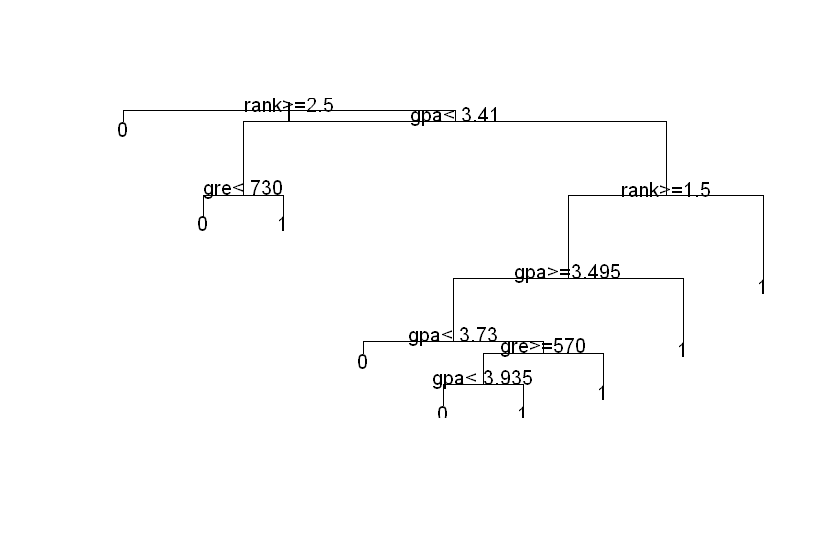

In [53]:
plot(tree)
text(tree)

In [73]:
dt_preds = test_students %>%
    add_predictions(tree)
# we do some random crap here because tree predictions are weird
dt_preds$pred = dt_preds$pred[,2]
dt_preds

admit,gre,gpa,rank,id,pred
0,440,3.22,1,12,0.2840909
0,560,3.49,4,376,0.2189349
1,800,3.70,1,119,0.7586207
0,440,2.48,4,49,0.2189349
0,800,3.31,3,201,0.2189349
...,...,...,...,...,...
1,680,3.85,3,64,0.2189349
1,800,3.22,1,287,0.6250000
0,660,3.34,3,55,0.2189349
0,560,3.19,3,57,0.2189349


In [74]:
test_mm_preds =
    bind_rows(Full=test_preds,
              GPA=test_gpa_preds,
              Tree=dt_preds,
              .id="Model")
test_mm_preds

Model,admit,gre,gpa,rank,id,pred
Full,0,440,3.22,1,12,-0.4029496
Full,0,560,3.49,4,376,-1.6004636
Full,1,800,3.70,1,119,0.6486131
Full,0,440,2.48,4,49,-2.5805971
Full,0,800,3.31,3,201,-0.7266108
...,...,...,...,...,...,...
Tree,1,680,3.85,3,64,0.2189349
Tree,1,800,3.22,1,287,0.6250000
Tree,0,660,3.34,3,55,0.2189349
Tree,0,560,3.19,3,57,0.2189349


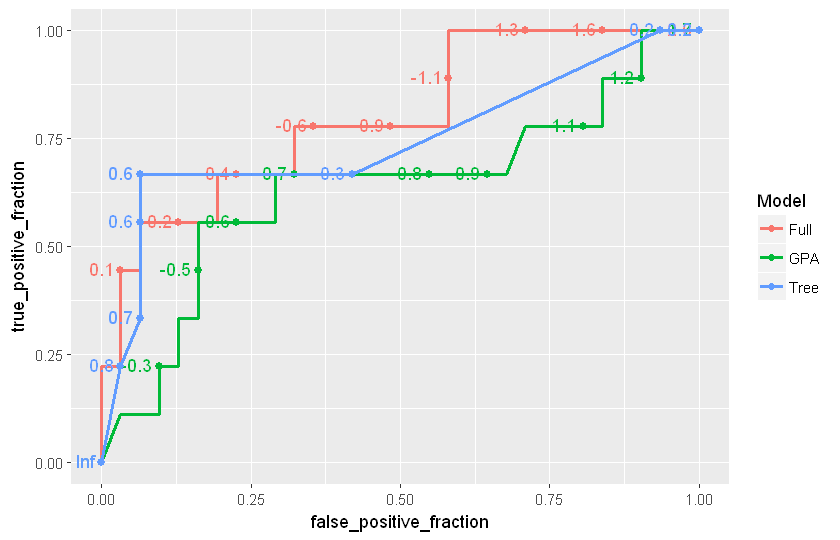

In [75]:
mm_plot = ggplot(test_mm_preds) +
    aes(d=admit, m=pred, color=Model) +
    geom_roc()
mm_plot